In [105]:
import numpy as np
import math
import torch
import sys
from matplotlib import pyplot as plt

In [57]:
if sys.platform == "darwin":
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Q 3.1

### Logistic Regression

In [193]:
class LinearLogisticRegression(torch.nn.Module):
    def __init__(self):
        super(LinearLogisticRegression, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(4, 1, bias=True),
            torch.nn.Sigmoid()
        )
        self.layers[0].state_dict()['weight'].zero_()
        return
    def forward(self, x):
        x = x.view(-1, 4)
        return self.layers(x)

class KernelLogisticRegression(torch.nn.Module):
    def __init__(self):
        super(LinearLogisticRegression, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(4, 1, bias=True),
            torch.nn.Sigmoid()
        )
        self.layers[0].state_dict()['weight'].zero_()
        return
    def forward(self, x):
        x = x.view(-1, 4)
        return self.layers(x)

def run_knn(k, X_train, Y_train, X_test):
    distances = -2*(X_test@X_train.T) + \
                torch.sum(torch.square(X_train), axis=1) + \
                torch.sum(torch.square(X_test), axis=1).unsqueeze_(-1)
    sorted_indices = torch.argsort(distances, axis = 1)[:, :k]
    knn = Y_train[sorted_indices].astype(np.int32)
    return knn

## Q 3.2

In [59]:
# Create Dataset
mu = torch.tensor([2.5, 0])
a  = []
b = []
for _ in range(750):
    a.append(torch.normal(mu, torch.eye(2)).view(2,2))
    b.append(torch.normal(-mu, torch.eye(2)).view(2,2))

postive_data_points = torch.stack(a).view(750, 2, 2)
negative_data_points = torch.stack(b).view(750, 2, 2)

In [60]:
data_set = torch.cat((postive_data_points, negative_data_points))
labels = torch.cat((torch.ones(750, 1), torch.zeros(750, 1)))
shuffle_index = torch.randperm(data_set.shape[0])
data_set = data_set[shuffle_index]
labels = labels[shuffle_index]

In [111]:
permuted_indices = torch.randperm(data_set.shape[0])
training_data = data_set[permuted_indices[:1000]]
training_labels = labels[permuted_indices[:1000]]
validation_data = data_set[permuted_indices[1000:1250]]
validation_labels = labels[permuted_indices[1000:1250]]
test_data = data_set[permuted_indices[1250:1500]]
test_labels = labels[permuted_indices[1250:1500]]

# Create dataloaders
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, i):
        return self.data[i], self.labels[i] 

training_set = Dataset(training_data, training_labels)
train_loader = torch.utils.data.DataLoader(training_set, shuffle=True, batch_size=256)
validation_set = Dataset(validation_data, validation_labels)
validation_loader = torch.utils.data.DataLoader(validation_set, shuffle=True, batch_size=250)
test_set = Dataset(test_data, test_labels)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=True, batch_size=250)

In [130]:
def get_prediction(model, data):
    return model(data).detach()

def get_accuracy(predictions, labels):
    threshold = torch.tensor([0.5])
    predictions = (predictions >= threshold).float()*1
    return float(torch.count_nonzero((labels == predictions)))/float(len(labels))

def report_acc_decision_boundary(model, test_set_loader):
    for data, labels in test_set_loader:
        predictions = get_prediction(model, data)
        accuracy = get_accuracy(predictions, labels)
        print(f" Accuracy of model on test set: {accuracy*100}%")
    return

def train_logistic_regression(model, train_loader, validation_loader, learning_rate, losses):
    criterion = torch.nn.BCELoss(reduction='mean')
    threshold = 1e-5
    loss_reduction = 1.0
    optim = torch.optim.SGD(model.parameters(), learning_rate)
    prev_loss = math.inf
    curr_loss = math.inf

    while loss_reduction >= threshold:
        for x, y in train_loader:
            # Train model on training set
            y_hat = model(x)
            loss = criterion(y_hat, y)
            optim.zero_grad()
            loss.backward()
            optim.step()

            # Evaluate on validation set
        for val_data, val_labels in validation_loader:
            val_predictions = get_prediction(model, val_data)
            curr_loss = criterion(val_predictions, val_labels).item()
        loss_reduction = abs(curr_loss/prev_loss - 1.0)
        prev_loss = curr_loss
        losses.append(prev_loss)


In [122]:
linear_lr_model = LinearLogisticRegression()
losses = []
train_logistic_regression(linear_lr_model, train_loader, validation_loader, 0.0075, losses)

In [131]:
report_acc_decision_boundary(linear_lr_model, test_loader)

 Accuracy of model on test set: 100.0%


/tmp/ipykernel_20274/341783157.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


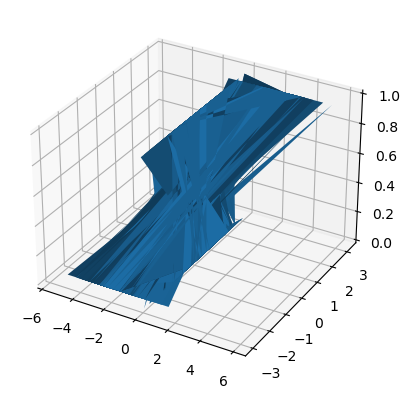

In [154]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(training_data[:, 0], training_data[:, 1], training_labels)

### Q 3.2

In [157]:
import sklearn
from sklearn import datasets

In [192]:
data_set_tuples = sklearn.datasets.make_circles()

data_set = torch.zeros((len(data_set_tuples[0]), 2), dtype=torch.float)
labels = torch.zeros((len(data_set_tuples[0]), 1), dtype=torch.float)
data_set.copy_(torch.from_numpy(data_set_tuples[0].astype(np.float32)))
labels.copy_(torch.from_numpy(data_set_tuples[1].astype(np.float32)).view((len(data_set_tuples[0]), 1)))
permuted_indices = torch.randperm(data_set.shape[0])
training_data = data_set[permuted_indices[:1000]]
training_labels = labels[permuted_indices[:1000]]
validation_data = data_set[permuted_indices[1000:1250]]
validation_labels = labels[permuted_indices[1000:1250]]
test_data = data_set[permuted_indices[1250:1500]]
test_labels = labels[permuted_indices[1250:1500]]

(array([[ 9.92114701e-01,  1.25333234e-01],
        [-9.68583161e-01, -2.48689887e-01],
        [-6.37423990e-01, -7.70513243e-01],
        [-4.28661436e-01, -6.75462340e-01],
        [ 2.47213595e-01, -7.60845213e-01],
        [ 5.02324156e-02, -7.98421383e-01],
        [ 7.43821189e-01,  2.94499642e-01],
        [-6.47213595e-01,  4.70228202e-01],
        [-3.09016994e-01,  9.51056516e-01],
        [-1.87381315e-01,  9.82287251e-01],
        [-1.00000000e+00, -3.21624530e-16],
        [-9.29776486e-01,  3.68124553e-01],
        [-9.29776486e-01, -3.68124553e-01],
        [-7.01045344e-01, -3.85402939e-01],
        [ 1.87381315e-01,  9.82287251e-01],
        [ 6.47213595e-01,  4.70228202e-01],
        [ 9.29776486e-01, -3.68124553e-01],
        [ 9.68583161e-01,  2.48689887e-01],
        [-1.87381315e-01, -9.82287251e-01],
        [-5.35826795e-01,  8.44327926e-01],
        [ 7.28968627e-01,  6.84547106e-01],
        [ 7.01045344e-01, -3.85402939e-01],
        [ 3.40623433e-01,  7.238